In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [18]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('a b x g p E')

In [20]:
EXPR1 = (1-p) * (a*sp.exp(-b+x) + a**2*(1-sp.exp(-b+x))+ a*(1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g))
EXPR1

(1 - p)*(a**2*(1 - exp(-b + x)) + a*(1 - a)*(1 - exp(-b + x))*(a + g*(1 - a)) + a*exp(-b + x))

In [21]:
EXPR2 = p * (a*sp.exp(-b+E+x)+a**2*(1-sp.exp(-b+E+x))+a*(1-a)*(1-sp.exp(-b+E+x))*(a+(1-a)*g))
EXPR2

p*(a**2*(1 - exp(E - b + x)) + a*(1 - a)*(1 - exp(E - b + x))*(a + g*(1 - a)) + a*exp(E - b + x))

In [22]:
p0 = p1 / (a*p*(1-sp.exp(-b+E))+a*(1-p)*(1-sp.exp(-b)))
p0

p_1/(a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b)))

In [25]:
lowIntegrand = sp.simplify(p0 *(EXPR1 + EXPR2)*sp.exp(-x))
lowIntegral  = sp.simplify(sp.integrate(lowIntegrand, (x, 0, b-E)))
lowIntegral

Piecewise((p_1*(-(E - b)*(a**2*g*p*exp(E) - a**2*g*p + a**2*g - a**2*p*exp(E) + a**2*p - a**2 - 2*a*g*p*exp(E) + 2*a*g*p - 2*a*g + 2*a*p*exp(E) - 2*a*p + 2*a + g*p*exp(E) - g*p + g - p*exp(E) + p - 1) + (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(b) + (a**2*g - a**2 - 2*a*g + 2*a + g)*exp(E))/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (p_1*(E - b)*(-a**2*g*p*exp(E) + a**2*g*p + a**2*p*exp(E) - a**2*p + 2*a*g*p*exp(E) - 2*a*g*p - 2*a*p*exp(E) + 2*a*p - g*p*exp(E) + g*p + p*exp(E) - p + 1)/(p*exp(E) - p - exp(b) + 1), True))

In [26]:
medIntegrand = sp.simplify(p0 *(p*a + EXPR2)*sp.exp(-x))
medIntegral  = sp.simplify(sp.integrate(medIntegrand, (x, b-E, b)))
medIntegral

Piecewise((p*p_1*(a**2*g - a**2 - 2*a*g + 2*a + b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + g + (E - b)*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + (-a**2*g + a**2 + 2*a*g - 2*a - g - 1)*exp(E) + 1)/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (E*p*p_1*(a**2*g*exp(E) - a**2*g - a**2*exp(E) + a**2 - 2*a*g*exp(E) + 2*a*g + 2*a*exp(E) - 2*a + g*exp(E) - g - exp(E) - 1)/(p*exp(E) - p - exp(b) + 1), True))

In [27]:
highIntegrand = sp.simplify(p0*a*sp.exp(-x))
highIntegral  = sp.simplify(sp.integrate(highIntegrand, (x, b, sp.oo)))
highIntegral

Piecewise((-p_1/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (Piecewise((nan, Eq(p_1/(p*exp(E) - p - exp(b) + 1), 0)), (p_1*(b*Abs(p_1/(p*exp(E) - p - exp(b) + 1)) - oo)/((p*exp(E) - p - exp(b) + 1)*Abs(p_1/(p*exp(E) - p - exp(b) + 1))), True)), True))

In [28]:
sp.simplify(lowIntegral + medIntegral + highIntegral)

Piecewise((p_1*(p*(a**2*g - a**2 - 2*a*g + 2*a + b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + g + (E - b)*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + (-a**2*g + a**2 + 2*a*g - 2*a - g - 1)*exp(E) + 1) - (E - b)*(a**2*g*p*exp(E) - a**2*g*p + a**2*g - a**2*p*exp(E) + a**2*p - a**2 - 2*a*g*p*exp(E) + 2*a*g*p - 2*a*g + 2*a*p*exp(E) - 2*a*p + 2*a + g*p*exp(E) - g*p + g - p*exp(E) + p - 1) - (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(E) - (a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b) - 1)/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (nan, Eq(p_1/(p*exp(E) - p - exp(b) + 1), 0)), (p_1*(b*Abs(p_1/(p*exp(E) - p - exp(b) + 1)) + (-E*p*(-a**2*g*exp(E) + a**2*g + a**2*exp(E) - a**2 + 2*a*g*exp(E) - 2*a*g - 2*a*exp(E) + 2*a - g*exp(E) + g + exp(E) + 1) + (E - b)*(-a**2*g*p*exp(E) + a**2*g*p + a**2*p*exp(E) - a**2*p + 2*a*g*p*exp(E) - 2*a*g*p - 2*a*p*exp(E) + 2*a*p - g*p*exp(E) + g*p + p*exp(E) - p + 1))*Abs(p_1/(p*exp(E) - p - exp(b) + 1)) - oo)/((p*exp(E) - p - exp(b) + 1)*Abs(p_1/(p

In [3]:
f0p0high = p1 / (1-sp.exp(-b)) * sp.integrate(sp.exp(-x), (x, b, sp.oo))
f0p0high

p_1*exp(-b)/(1 - exp(-b))

In [4]:
integrand = p1 * sp.exp(-x) * (sp.exp(-b+x) + a*(1-sp.exp(-b+x)) + (1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)) / (1-sp.exp(-b))
f0p0low = sp.integrate(integrand, (x,0,b))
f0p0low

b*(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + Piecewise((-(-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))/(exp(b) - 1) + (-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))*exp(-b)/(exp(b) - 1), Ne(b, 0)), (b*(-(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + (a**2*g*p_1*exp(b) - a**2*g*p_1 - a**2*p_1*exp(b) + a**2*p_1 - 2*a*g*p_1*exp(b) + 2*a*g*p_1 + 2*a*p_1*exp(b) - 2*a*p_1 + g*p_1*exp(b) - g*p_1 + p_1)/(exp(b) - 1)), True))

In [5]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [6]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

Piecewise((-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) - (2*a - 1)*(exp(b) - 1)*(a**2*g - 2*a*g - a*(a - 2) - a*(a - 1) + 2*a + g))/((2*a - 1)*(exp(b) - 1)), (b > 0) | (b < 0)), (-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) + (2*a - 1)*(a*(1 - exp(b))*(3 - a) - b*(a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b)))/((2*a - 1)*(exp(b) - 1)), True))

In [7]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-b)))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [8]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b) - 2*a - exp(b) + 1)/(3*a**2*exp(b) - 3*a**2 + 2*a - exp(b))

In [9]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

Piecewise((a*(-2.0*a**2*(exp(b) - 1) - (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(exp(b) - 1.0)*(a**2*g - 2.0*a*g - a*(a - 2.0) - a*(a - 1.0) + 2.0*a + g))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), (b > 0) | (b < 0)), (-a*(2.0*a**2*(exp(b) - 1) + (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(a*(a - 3.0)*(exp(b) - 1.0) - b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g)*exp(b)))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), True))

In [10]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [11]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [16]:
alpha  = 0.33
betas  = np.arange(0.1, 10, 0.01)
gammas = [0., 0.5, 1.]

resMines = []
resTheir = []
for g in gammas:
    resMines.append(finalLambda(alpha, betas, g))
    resTheir.append(Carlsten(alpha, betas, g))

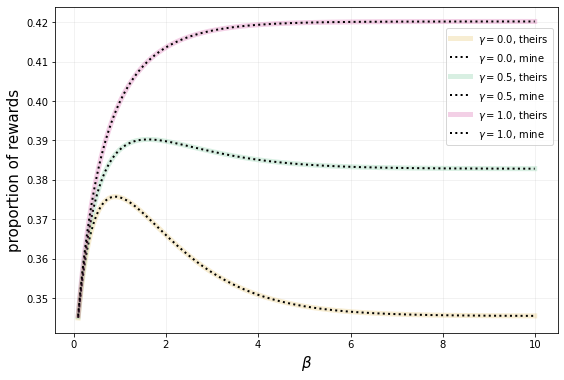

In [17]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=0.2,
            label='$\gamma={:0.1f}$, theirs'.format(gammas[i]), 
            linestyle='-', linewidth=5)
    ax.plot(betas, resMines[i], color='k', alpha=1, 
            label='$\gamma={:0.1f}$, mine'.format(gammas[i]),
            linestyle='dotted', linewidth=2)


ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()